In [1]:
# Real life data

import logging
import threading
import itertools
#import modin.pandas as pd  
import pandas as pd
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScoreExt,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, BayesRidgeRegressorExt)
from mmfunctions.anomaly import (FeatureBuilder, GBMRegressor, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
import datetime as dt
#import pymc3 as pm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

ModuleNotFoundError: No module named 'poc'

In [9]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-11-12T11:36:12.871 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [2]:
def prepData(fileName, valueName):
    # Run on the good pump first 
    # Get stuff in
    df_i = pd.read_csv(fileName, index_col=False, parse_dates=['t_stamp'])
    #t_stamp,CA1/CDA/AC_Comp1/InterCoolTemp

    entity_name = [x for x in df_i.columns if not x.startswith('t_stamp')][0]
    entity_name_ = entity_name.replace('/','_')

    df_i['entity']=entity_name_  # NO SLASHES IN FILESYSTEM !
    df_i.rename(columns={'t_stamp':'timestamp', entity_name:valueName}, inplace=True)

    # and sort it by timestamp
    df_i = df_i.sort_values(by='timestamp')
    df_i = df_i.set_index(['entity','timestamp']).dropna()

    return df_i

def runSpectral(df_i):
    jobsettings = { 'db': db, 
                   '_db_schema': 'public', 'save_trace_to_file' : True}

    Temperature = df_i.columns[0]
    spectral = Temperature + 'spectral'
    spectralinv = Temperature + 'spectralinv'
    
    spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv)
    et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
    spsi._entity_type = et
    df_i = spsi.execute(df=df_i)
    return df_i

def computeL2Deriv(df_i, winsize, valueName):
    df_m = df_i.reset_index().set_index('timestamp')

    # partial L2-norm of 1st derivative
    Temperature = df_i.columns[0]
    
    temperature = df_m[Temperature].values
    slices_ = skiutil.view_as_windows(temperature, window_shape=(winsize,), step=1)

    Dslice_list = []
    for slice in slices_:
        Dslice_list.append(sp.linalg.norm(np.diff(slice)))
    DSlice = np.asarray(Dslice_list)

    #stretch it
    time_series_temperature = np.linspace(winsize // 2, temperature.size - winsize // 2 - 1, DSlice.size)

    temp_dl2_inter = sp.interpolate.interp1d(time_series_temperature, DSlice,
                                              kind='linear', fill_value='extrapolate')
    df_m['Fluctuation'] = temp_dl2_inter(np.arange(0, temperature.size))
    return df_m
    
def plotData(df_i, label, title, scale=[1,100,1]):
    df_m = df_i.reset_index().set_index('timestamp')
    plots = 1

    Temperature = df_i.columns[0]
    spectral = Temperature + 'spectral'
    spectralinv = Temperature + 'spectralinv'
    
    fig, ax = plt.subplots(plots, 1, figsize=(15,10), squeeze=False)
    cnt = 0
    if scale[0] > 0:
        ax[cnt,0].plot(df_m.index, df_m[Temperature]/scale[0],linewidth=1,color='blue',label=label)
    if scale[1] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectral]/scale[1], linewidth=1, color='orange', label='Anomalous Activity')
    if scale[2] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectralinv]/scale[2], linewidth=1, color='red', label='Low Activity')
    ax[cnt,0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[cnt,0].set_ylabel(title,fontsize=12,weight="bold")
    

In [5]:
#df_input = pd.read_csv('./1096_first_50_hours.csv', parse_dates=['RCV_TIMESTAMP_UTC', 'UPDATED_UTC']).dropna()
#df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])

df_input = pd.read_csv('./data/IOT_PUMP_DE_GEN5_202012141519.csv.bz2', compression='bz2',
                       parse_dates=['RCV_TIMESTAMP_UTC', 'UPDATED_UTC']) #.dropna()
df_input = df_input.drop(columns=['DEVICETYPE','ID','LOGICALINTERFACE_ID','EVENTTYPE','FORMAT',
                                  'PUMP_MODE','WARN','TIMESTAMP','VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS',
                                  'VIBRATIONS_ZAXIS','REATED_POWER','RMSN_X', 'RMSN_Y', 'RMSN_Z', 'HW_VER',
                                  'DQ','FW_VER', 'HEAD','TAG_NUMBER','PTS', 'PTS_COUNT', 'VIBRATION_N_XAXIS',
                                  'VIBRATION_N_YAXIS','VIBRATION_N_ZAXIS', 'RMS_X', 'RMS_Y', 'RMS_Z', 'RUN_QTY',
                                  'RMS_X_AVG', 'HARDWARE_VER', 'RATED_SPEED', 'PERF_OPTION', 'RATED_CURRENT',
                                  'ACCEL_POWER', 'ACCEL_SPEED', 'VERSION', 'DESIGN_FLOW', 'SERIAL_NUMBER',
                                  'FIRMWARE_VER', 'PWR', 'DESIGN_HEAD']).dropna()
df_input = df_input.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])
#df_input.index = df_input.index.drop_duplicates()

df_input = df_input[~df_input.index.duplicated(keep='first')]
df_input

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (0,21,23,25,26,27,28,31,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


UPDATED_UTC   SPEED  \
DEVICEID     RCV_TIMESTAMP_UTC                                                
04714B601096 2019-12-17-08.13.33.820000  2019-12-17-08.13.33.000000  1160.0   
             2019-12-17-08.18.34.204000  2019-12-17-08.18.34.000000  1180.0   
             2019-12-17-08.23.34.315000  2019-12-17-08.23.34.000000  1164.0   
             2019-12-17-08.28.34.597000  2019-12-17-08.28.34.000000  1176.0   
             2019-12-17-08.33.34.636000  2019-12-17-08.33.34.000000  1175.0   
...                                                             ...     ...   
             2020-12-14-12.53.41.230000  2020-12-14-12.53.41.000000  1107.0   
             2020-12-14-12.58.41.693000  2020-12-14-12.58.41.000000  1088.0   
             2020-12-14-13.03.41.815000  2020-12-14-13.03.41.000000  1094.0   
             2020-12-14-13.08.42.364000  2020-12-14-13.08.42.000000  1085.0   
             2020-12-14-13.13.42.222000  2020-12-14-13.13.42.000000  1083.0   

                                         TEMPERATURE     DEVICE_ID     FLOW  \
DEVICEID     RCV_TIMESTAMP_UTC                                                
04714B601096 2019-12-17-08.13.33.820000         47.7  04714B601096  141.852   
             2019-12-17-08.18.34.204000         47.7  04714B601096  153.554   
             2019-12-17-08.23.34.315000         47.5  04714B601096  145.109   
             2019-12-17-08.28.34.597000         47.3  04714B601096  152.987   
             2019-12-17-08.33.34.636000         47.7  04714B601096  151.237   
...                                              ...           ...      ...   
             2020-12-14-12.53.41.230000         47.7  04714B601096  103.599   
             2020-12-14-12.58.41.693000         47.8  04714B601096   84.284   
             2020-12-14-13.03.41.815000         47.7  04714B601096   93.135   
             2020-12-14-13.08.42.364000         47.9  04714B601096   81.436   
             2020-12-14-13.13.42.222000         47.8  04714B601096   78.928   

                                            KW_HOUR  VOLTAGE  ALARM  POWER  \
DEVICEID     RCV_TIMESTAMP_UTC                                               
04714B601096 2019-12-17-08.13.33.820000  274614.031    288.0    0.0  3.180   
             2019-12-17-08.18.34.204000  274614.031    296.0    0.0  3.440   
             2019-12-17-08.23.34.315000  274614.031    290.0    0.0  3.230   
             2019-12-17-08.28.34.597000  274614.031    294.0    0.0  3.418   
             2019-12-17-08.33.34.636000  274614.031    294.0    0.0  3.372   
...                                             ...      ...    ...    ...   
             2020-12-14-12.53.41.230000  293064.906    269.0    0.0  2.470   
             2020-12-14-12.58.41.693000  293064.906    263.0    0.0  2.208   
             2020-12-14-13.03.41.815000  293067.219    265.0    0.0  2.328   
             2020-12-14-13.08.42.364000  293067.219    262.0    0.0  2.168   
             2020-12-14-13.13.42.222000  293067.219    261.0    0.0  2.137   

                                         CURRENT  
DEVICEID     RCV_TIMESTAMP_UTC                    
04714B601096 2019-12-17-08.13.33.820000     9.35  
             2019-12-17-08.18.34.204000     9.74  
             2019-12-17-08.23.34.315000     9.44  
             2019-12-17-08.28.34.597000     9.73  
             2019-12-17-08.33.34.636000     9.64  
...                                          ...  
             2020-12-14-12.53.41.230000     8.47  
             2020-12-14-12.58.41.693000     8.03  
             2020-12-14-13.03.41.815000     8.26  
             2020-12-14-13.08.42.364000     8.01  
             2020-12-14-13.13.42.222000     7.97  

[57726 rows x 10 columns]

In [6]:
#df_input[['SPEED']].plot()
#df_input[['POWER']].plot()

In [10]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = BayesRidgeRegressorExt(['SPEED'], ['POWER'], degree=3)
#spsi = GBMRegressor(['SPEED'], ['POWER'], learning_rate=0.1)


et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_iii = spsi.execute(df=df_input[0:300])

#df_iii = spsi.execute(df=df_input[0:300])

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2021-11-12T11:36:20.818 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-12T11:36:20.820 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.6.0
2021-11-12T11:36:20.822 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-12T11:36:20.823 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressorExt_20211112103620
2021-11-12T11:36:20.824 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-12T11:36:20.827 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-12T11:36:20.828 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-12T11:36:20.829 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOREXT
Functions:
Granularities:
No schedules metadata
2021-11-12T11:36:20.831 DEBUG mmfunctions.anomaly.execute Execute BayesianRidgeRegress

CPU times: user 111 ms, sys: 10.4 ms, total: 121 ms
Wall time: 110 ms


/home/markus/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,SPEED,TEMPERATURE,FLOW,KW_HOUR,VOLTAGE,ALARM,POWER,CURRENT
count,57726.000000,57726.000000,57726.000000,57726.000000,57726.000000,57726.0,57726.000000,57726.000000
mean,1082.931591,50.444715,68.549736,285021.114533,261.309081,0.0,2.124227,7.921309
std,50.623965,2.858125,43.444764,4873.548795,18.578066,0.0,0.707765,0.920695
min,502.000000,43.800000,0.000000,274614.031000,108.000000,0.0,0.283000,5.120000
25%,1059.000000,47.900000,37.778750,282824.813000,253.000000,0.0,1.732000,7.390000
50%,1061.000000,50.000000,43.440000,286133.531000,253.000000,0.0,1.778000,7.460000
75%,1090.000000,53.200000,93.052750,288444.500000,263.000000,0.0,2.235000,8.110000
max,1513.000000,56.800000,297.684000,293069.500000,441.000000,0.0,9.188000,15.370000


In [11]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = BayesRidgeRegressorExt(['SPEED'], ['POWER'], degree=3)
#spsi = GBMRegressor(['SPEED'], ['POWER'], learning_rate=0.1)


et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_iii = spsi.execute(df=df_input)

#df_iii = spsi.execute(df=df_input[0:300])

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2021-11-12T11:36:24.034 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-12T11:36:24.037 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.6.0
2021-11-12T11:36:24.039 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-12T11:36:24.040 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressorExt_20211112103624
2021-11-12T11:36:24.040 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-12T11:36:24.040 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-12T11:36:24.041 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-12T11:36:24.041 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOREXT
Functions:
Granularities:
No schedules metadata
2021-11-12T11:36:24.042 DEBUG mmfunctions.anomaly.execute Execute BayesianRidgeRegress

,SPEED,TEMPERATURE,FLOW,KW_HOUR,VOLTAGE,ALARM,POWER,CURRENT
count,57726.000000,57726.000000,57726.000000,57726.000000,57726.000000,57726.0,57726.000000,57726.000000
mean,1082.931591,50.444715,68.549736,285021.114533,261.309081,0.0,2.124227,7.921309
std,50.623965,2.858125,43.444764,4873.548795,18.578066,0.0,0.707765,0.920695
min,502.000000,43.800000,0.000000,274614.031000,108.000000,0.0,0.283000,5.120000
25%,1059.000000,47.900000,37.778750,282824.813000,253.000000,0.0,1.732000,7.390000
50%,1061.000000,50.000000,43.440000,286133.531000,253.000000,0.0,1.778000,7.460000
75%,1090.000000,53.200000,93.052750,288444.500000,263.000000,0.0,2.235000,8.110000
max,1513.000000,56.800000,297.684000,293069.500000,441.000000,0.0,9.188000,15.370000


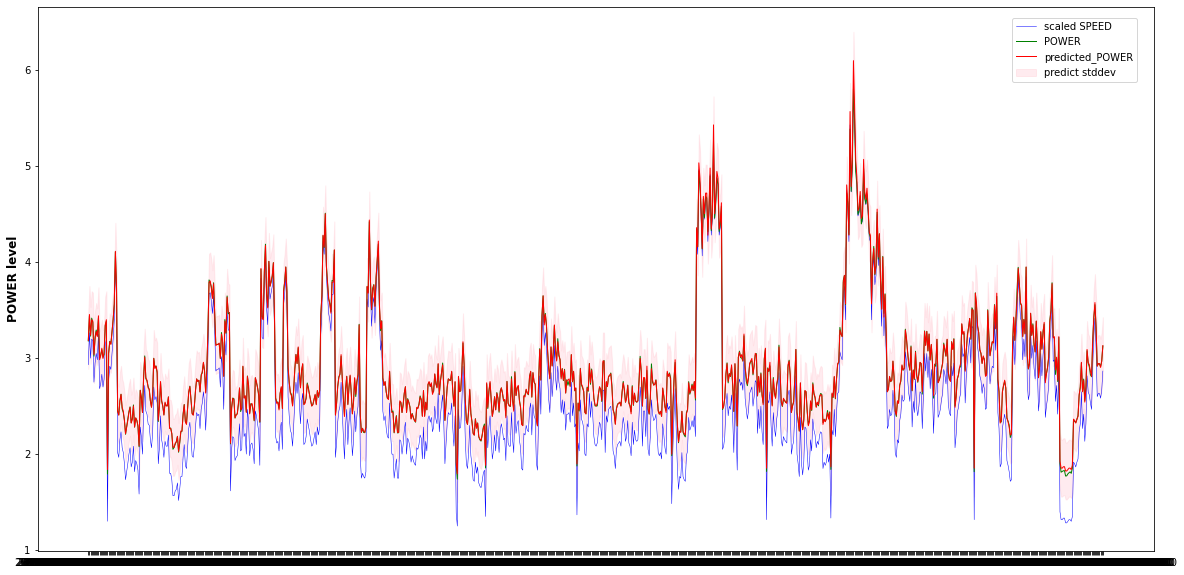

In [12]:
df_i = df_iii[0:900] # df_input
feature='SPEED'
target='POWER'
prediction='predicted_POWER'
pred_stddev='stddev_POWER'

plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[feature]/60-16.4,linewidth=0.5,color='blue',label='scaled ' + feature)
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[target],linewidth=1,color='green',label=target)
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[prediction],linewidth=1,color='red',label=prediction)
ax[cnt,0].fill_between(df_i.unstack(level=0).index, df_i[prediction] - df_i[pred_stddev],
                df_i[prediction] + df_i[pred_stddev], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(0.99, 0.99))
ax[cnt,0].set_ylabel('POWER level',fontsize=12,weight="bold")
cnt = 1

In [13]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gbmi = GBMForecaster(['POWER'], ['POWER'], ['POWER_fore'], [1,2,3,4,5,6,7,8,9,10])
#spsi = GBMRegressor(['SPEED'], ['POWER'], learning_rate=0.1)


et = gbmi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
gbmi._entity_type = et
df_input = gbmi.execute(df=df_input)

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2021-11-12T11:36:33.998 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-12T11:36:33.999 DEBUG mmfunctions.anomaly.lag_features lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  lagged_features ['POWER'] Train mode: True
2021-11-12T11:36:34.000 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.6.0
2021-11-12T11:36:34.000 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-12T11:36:34.000 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20211112103634
2021-11-12T11:36:34.001 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-12T11:36:34.001 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-12T11:36:34.001 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-12T11:36:34.002 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Function

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM]

,SPEED,TEMPERATURE,FLOW,KW_HOUR,VOLTAGE,ALARM,POWER,CURRENT,POWER_fore
count,57717.000000,57717.000000,57717.000000,57717.000000,57717.000000,57717.0,57717.000000,57717.000000,57717.000000
mean,1082.918620,50.445157,68.537628,285022.737231,261.304503,0.0,2.124048,7.921063,2.123916
std,50.617128,2.858128,43.437274,4872.195836,18.575847,0.0,0.707674,0.920554,0.690999
min,502.000000,43.800000,0.000000,274620.531000,108.000000,0.0,0.283000,5.120000,1.516385
25%,1059.000000,47.900000,37.777000,282824.813000,253.000000,0.0,1.732000,7.390000,1.733257
50%,1061.000000,50.000000,43.433000,286133.531000,253.000000,0.0,1.778000,7.460000,1.780662
75%,1090.000000,53.200000,93.004000,288444.500000,263.000000,0.0,2.235000,8.110000,2.251602
max,1513.000000,56.800000,297.684000,293069.500000,441.000000,0.0,9.188000,15.370000,9.131971


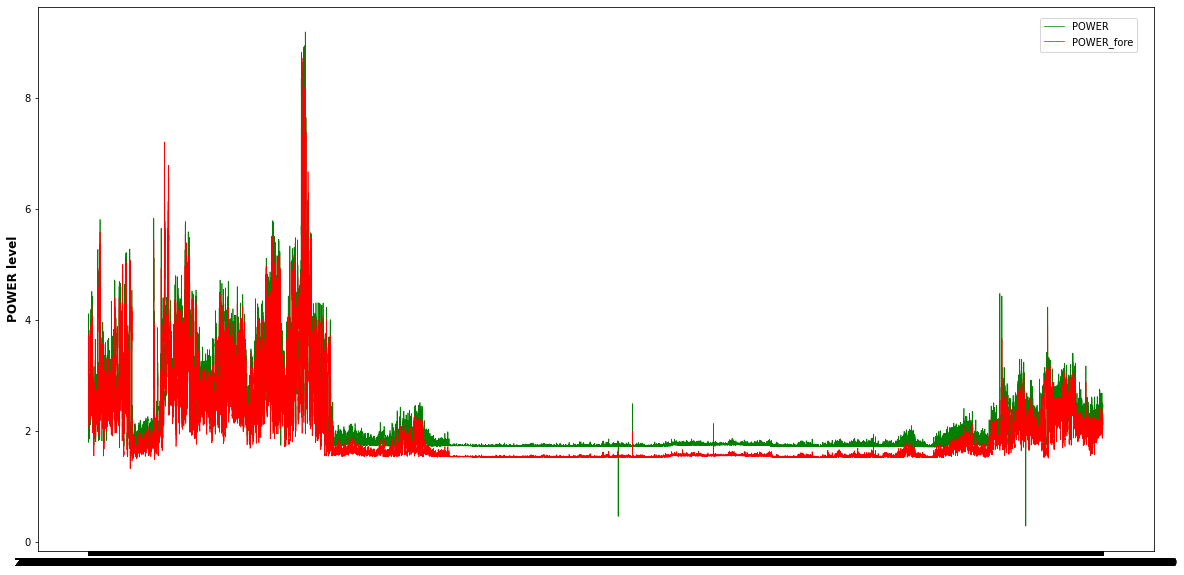

In [14]:
df_i = df_input
#feature='POWER'
target='POWER'
prediction='POWER_fore'
pred_stddev='stddev_POWER'

plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
#ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[feature]/60-16.4,linewidth=0.5,color='blue',label='scaled ' + feature)
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[target],linewidth=0.7,color='green',label=target)
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i[prediction]-0.2,linewidth=0.7,color='red',label=prediction)
#ax[cnt,0].fill_between(df_i.unstack(level=0).index, df_i[prediction] - df_i[pred_stddev],
 #               df_i[prediction] + df_i[pred_stddev], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(0.99, 0.99))
ax[cnt,0].set_ylabel('POWER level',fontsize=12,weight="bold")
cnt = 1

In [4]:
#df_input = prepData('~/Bldg3E HVAC Chilled Water Supply Chart.csv', 'temp')
#df_input = runSpectral(df_input)

2021-02-09T16:04:50.582 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-02-09T16:04:50.583 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.
2021-02-09T16:04:50.586 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


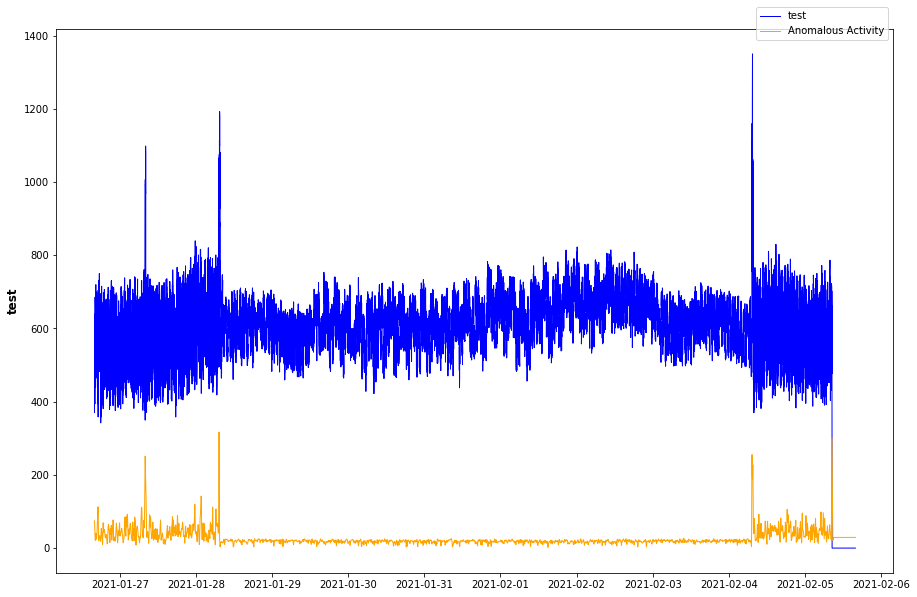

In [5]:
plotData(df_input, 'test', 'test', scale=[1,1,0])

In [6]:
df_input2 = prepData('~/Bldg3E HVAC Chilled Water Supply BypassFlow.csv', 'temp')
df_input2 = runSpectral(df_input2)

2021-02-09T16:04:51.564 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


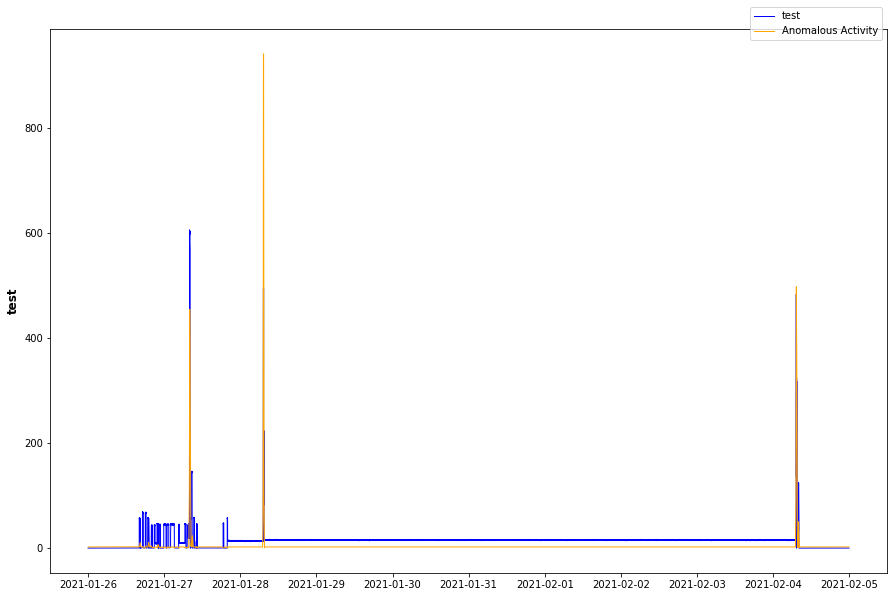

In [7]:
plotData(df_input2, 'test', 'test', scale=[1,1,0])

In [8]:
df_merge = pd.merge(df_input.reset_index(), df_input2.reset_index(),on='timestamp')
df_merge['entity'] = 'Chiller'
df_merge = df_merge.set_index(['entity','timestamp'])

In [9]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = KDEAnomalyScore(0.000001, ['temp_x'], ['temp_y'], ['tt_pred'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_merge = spsi.execute(df=df_merge)

EngineLogging.configure_console_logging(logging.INFO)
df_merge.describe()


2021-02-09T16:04:51.990 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-02-09T16:04:51.991 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2021-02-09T16:04:51.992 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-02-09T16:04:51.993 DEBUG iotfunctions.util.__init__ Starting trace
2021-02-09T16:04:51.993 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KDEAnomalyScore_20210209150451
2021-02-09T16:04:51.994 DEBUG iotfunctions.util.__init__ auto_save None
2021-02-09T16:04:51.994 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-02-09T16:04:51.995 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-02-09T16:04:51.996 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KDEANOMALYSCORE
Fu

,temp_x,tempspectral_x,tempspectralinv_x,temp_y,tempspectral_y,tempspectralinv_y,tt_pred
count,17256.000000,17256.000000,1.725600e+04,17256.000000,17256.000000,17256.000000,1.725600e+04
mean,615.619540,24.414491,1.193008e-01,16.202114,4.316086,0.478548,2.561109e-04
std,80.981863,20.068546,2.775638e-17,22.061159,31.439116,0.655296,1.351190e-04
min,342.056061,1.869826,1.193008e-01,0.000000,0.051955,0.315411,1.187383e-07
25%,562.868942,16.902352,1.193008e-01,14.778372,2.194742,0.315411,1.496194e-04
50%,617.634705,19.659898,1.193008e-01,15.353783,2.197149,0.315411,2.993349e-04
75%,668.396194,22.702487,1.193008e-01,15.980468,2.199182,0.315411,3.778426e-04
max,1350.042236,316.826648,1.193008e-01,605.981628,940.988924,3.170466,4.045989e-04


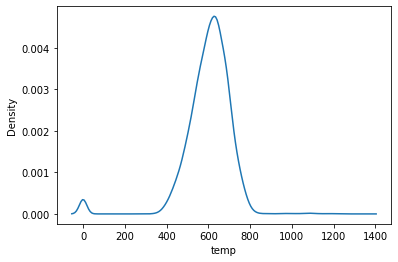

In [10]:
sns.kdeplot(data=df_input['temp'])


In [219]:
#https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-anomaly-detection-outliers-detection
from sklearn.neighbors import KernelDensity
X = df_input['temp'].values.reshape(-1,1)
kde = KernelDensity(kernel='gaussian')
kde.fit(X)
kde_X = kde.score_samples(X)

In [229]:
kde_X.shape

(9832,)

In [251]:
from scipy.stats.mstats import mquantiles

alpha_set = 0.995
tau_kde = mquantiles(kde_X, 1. - alpha_set)

tau_kde

array([-9.20074024])

In [281]:
outliers = np.argwhere(kde_X < tau_kde)
outliers = outliers.flatten()
X_outliers = X[outliers]

normal_samples = np.argwhere(kde_X >= tau_kde)
normal_samples = normal_samples.flatten()
X_valid = X[normal_samples]

print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", len(outliers))
print("Number of Normal Samples : ", len(normal_samples))

Original Samples :  9832
Number of Outliers :  49
Number of Normal Samples :  9783


In [287]:
mx_ = np.where(kde_X < tau_kde, kde_X, -10000).max()
mx = X[np.argwhere(kde_X == mx_).flatten()[0]][0]
mx

816.122924804687

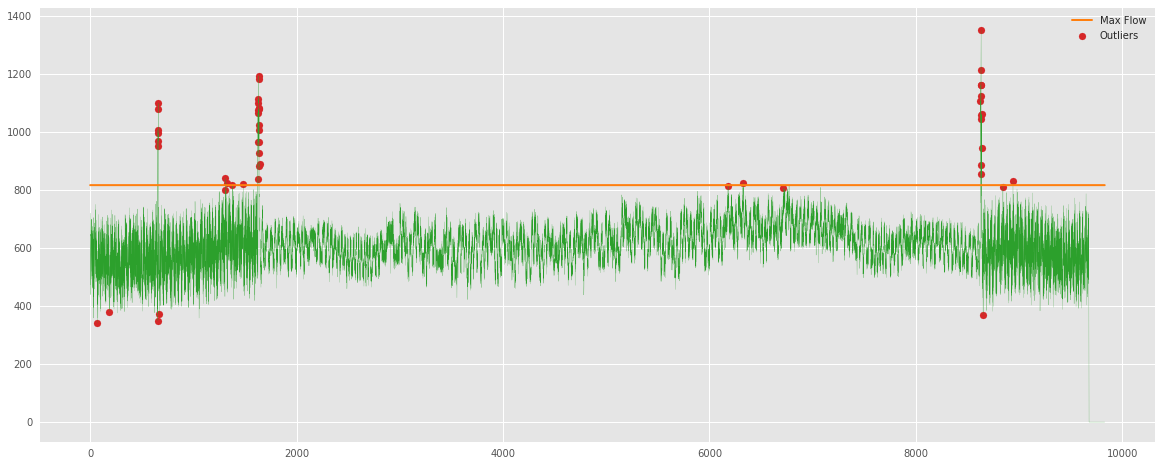

In [293]:
with plt.style.context(("seaborn", "ggplot")):
    plt.figure(figsize=(20,8))
    plt.plot(np.arange(0, X.shape[0], 1), X, c="tab:green", lw=0.2)
    plt.plot(np.arange(0,X.shape[0],1), np.ones(X.shape[0]) * mx, c="tab:orange", lw=2, label='Max Flow')
    #plt.plot(normal_samples, X_valid, c="tab:green", lw=0.2, label="Valid Samples")
    plt.scatter(outliers, X_outliers, c="tab:red", lw=0.2, label="Outliers")
    plt.legend(loc="best")
    

#plot_outliers_with_valid_samples(X_valid, X_outliers)

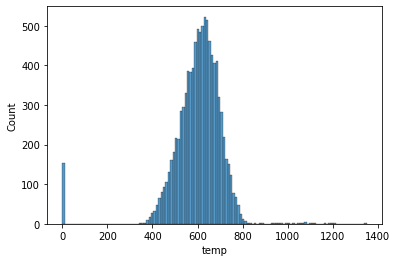

In [198]:
sns.histplot(data=df_input['temp'])

In [11]:
NO_DAY_OF_WEEK = True
df_input.index.get_level_values(1)

DatetimeIndex(['2021-01-26 15:59:00', '2021-01-26 15:59:00',
               '2021-01-26 16:01:00', '2021-01-26 16:01:00',
               '2021-01-26 16:04:00', '2021-01-26 16:04:00',
               '2021-01-26 16:07:00', '2021-01-26 16:07:00',
               '2021-01-26 16:10:00', '2021-01-26 16:10:00',
               ...
               '2021-02-05 15:30:00', '2021-02-05 15:33:00',
               '2021-02-05 15:35:00', '2021-02-05 15:38:00',
               '2021-02-05 15:41:00', '2021-02-05 15:44:00',
               '2021-02-05 15:47:00', '2021-02-05 15:50:00',
               '2021-02-05 15:53:00', '2021-02-05 15:56:00'],
              dtype='datetime64[ns]', name='timestamp', length=9845, freq=None)

In [22]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['temp'], ['temp'], ['temp_pred'], [1,2,3,4,5,6])

et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_input = spsi.execute(df=df_input)

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2021-02-09T16:07:24.522 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [1, 2, 3, 4, 5, 6]  lagged_features ['temp'] Train mode: True
2021-02-09T16:07:24.524 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-02-09T16:07:24.526 DEBUG iotfunctions.util.__init__ Starting trace
2021-02-09T16:07:24.529 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20210209150724
2021-02-09T16:07:24.532 DEBUG iotfunctions.util.__init__ auto_save None
2021-02-09T16:07:24.533 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-02-09T16:07:24.536 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-02-09T16:07:24.538 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granul

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] T

2021-02-09T16:07:27.401 DEBUG iotfunctions.base._execute Trained model: {
 "name": "model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU",
 "target": "temp",
 "features": [
  "temp_1",
  "temp_2",
  "temp_3",
  "temp_4",
  "temp_5",
  "temp_6"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.9787561807753178,
 "eval_metric_test": 0.7088045895290955,
 "trained_date": "2021-02-09T15:07:27.376369",
 "expiry_date": null,
 "col_name": "temp_pred",
 "col_name_stddev": null
}
2021-02-09T16:07:27.443 DEBUG iotfunctions.base.evaluate_and_write_model  wrote new model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU 
2021-02-09T16:07:27.444 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU
2021-02-09T16:07:27.444 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECAS

,temp,tempspectral,tempspectralinv,_DayOfWeekCos_,_DayOfWeekSin_,_DayOfYearCos_,_DayOfYearSin_,temp_pred,diff
count,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000
mean,601.596497,26.732297,0.241580,0.887588,0.387615,0.996342,0.085090,601.366324,67.980119
std,113.155252,21.418921,0.994371,0.107075,0.224687,0.000669,0.007821,107.430805,57.850712
min,0.000000,1.869826,0.119301,0.654600,0.000000,0.995140,0.071173,-3.712408,0.040000
25%,552.898987,17.282529,0.119301,0.841129,0.281843,0.995665,0.079368,561.216919,28.729974
50%,613.842010,20.324431,0.119301,0.909560,0.415572,0.996395,0.084829,612.980798,51.953062
75%,666.853882,26.066623,0.119301,0.959461,0.540834,0.996845,0.093016,658.788874,81.785538
max,1350.042236,316.826648,8.382176,1.000000,0.755975,0.997464,0.098470,1230.492696,544.813645


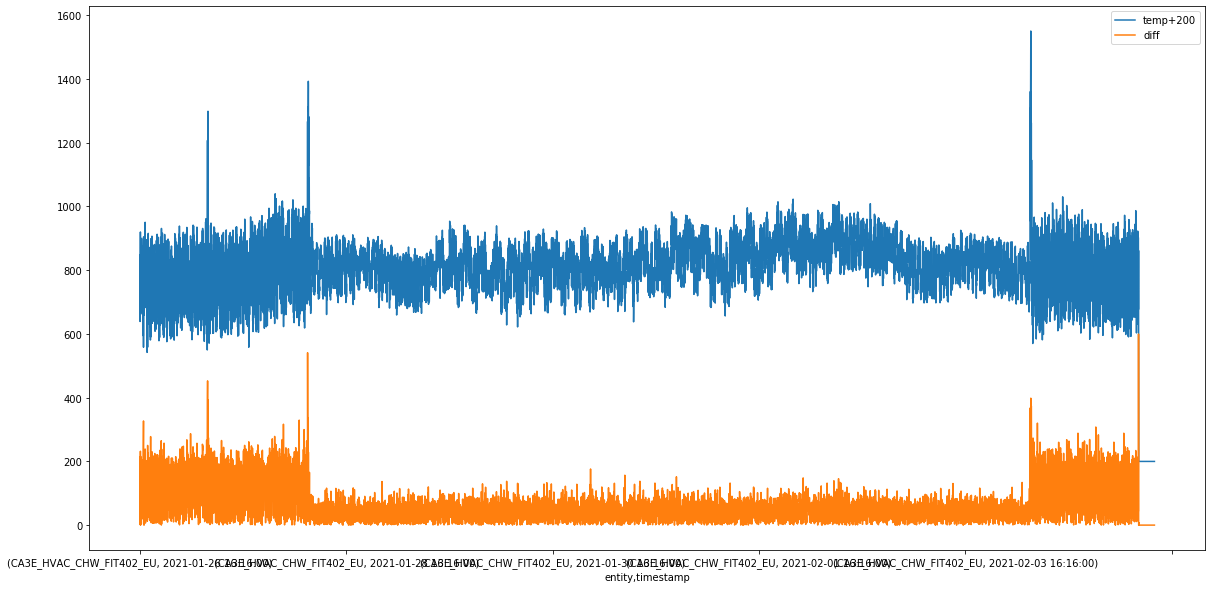

In [26]:
df_input2 = df_input[['temp','temp_pred']].copy()
df_input['diff'] = (df_input2['temp'] - df_input['temp_pred']).abs()
df_input['temp+200'] = df_input['temp'] + 200
df_input[['temp+200','diff']].plot(figsize=(20,10))

### Decompose into a mix of Gaussians

In [74]:
# https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
import pymc3 as pm
import theano.tensor as tt

from pymc3 import (NUTS, DensityDist, Dirichlet, Metropolis, MvNormal, Normal, Slice, find_MAP, sample)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )




In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_ = scaler.fit_transform(df_input['temp'].values.reshape(-1,1))
data = np.hstack([data, data])
data.shape

(9832, 4)

In [149]:
# define model
ncomp = 2
dim = 2

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))

    return logp_




with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(dim)), tau=pm.floatX(0.1 * np.eye(dim)), shape=(dim,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(ncomp)), shape=(ncomp,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(dim)), observed=data)

In [150]:
%%time
'''
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)
'''

with model:
    %time approx = pm.fit(n=40000, obj_optimizer=pm.adagrad(learning_rate=1e-2))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

Finished [100%]: Average Loss = 27,920


2021-02-10T18:47:43.918 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 27,920
CPU times: user 1min 14s, sys: 201 ms, total: 1min 14s
Wall time: 1min 14s
CPU times: user 1min 14s, sys: 201 ms, total: 1min 14s
Wall time: 1min 14s


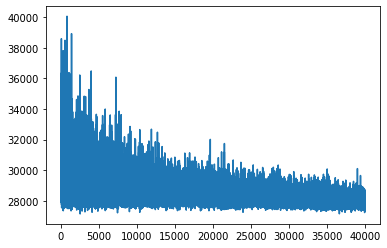

In [172]:
plt.plot(approx.hist)

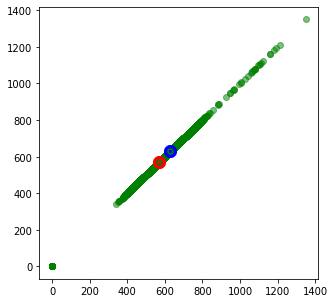

In [166]:
mu_0, mu_1 = scaler.inverse_transform(means["mu_0"]), scaler.inverse_transform(means["mu_1"])
data2 = scaler.inverse_transform(data[:, 0])

plt.figure(figsize=(5, 5))
plt.scatter(data2, data2, alpha=0.5, c="g")
#mu_0, mu_1 = means["mu_0"], means["mu_1"]
plt.scatter(mu_0[0], mu_0[1], c="r", lw=10, s=10)
plt.scatter(mu_1[0], mu_1[1], c="b", lw=10, s=10)
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)


In [183]:
from sklearn.mixture import BayesianGaussianMixture
nr_comp = 2

BGM = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
#BGM.mean_prior = [[2.3, 3.5, 0], [0,0,0]]
xy1 = df_input['temp'].values.reshape(-1,1)
BGM.fit(data_)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
Initialization converged: True


BayesianGaussianMixture(init_params='random', n_components=2, n_init=5,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [184]:
"weights", BGM.weights_, "means", BGM.means_, "precision", BGM.precisions_

('weights',
 array([0.96907695, 0.03092305]),
 'means',
 array([[ 0.07937514],
        [-2.48353173]]),
 'precision',
 array([[[2.02014735]],
 
        [[0.09582892]]]))

In [195]:
scaler.inverse_transform(BGM.means_), scaler.inverse_transform(BGM.precisions_), BGM.precisions_

(array([[610.57775432],
        [320.58613039]]),
 array([[[830.17515498]],
 
        [[612.43949143]]]),
 array([[[2.02014735]],
 
        [[0.09582892]]]))

[[609.09271413]] [[612.0627945]]


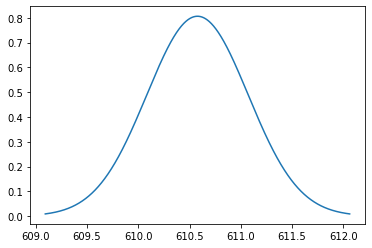

[[289.28034047]] [[351.89192031]]


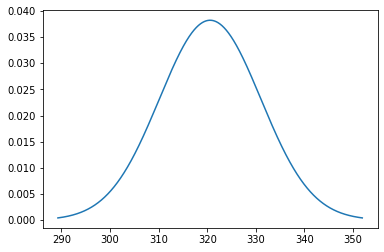

In [196]:
for i in [0,1]:
    mu = scaler.inverse_transform(BGM.means_[i])
    sigma = 1/BGM.precisions_[i]
    print (mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y = sp.stats.norm.pdf(x, mu, sigma).reshape(-1,)
    #print (y)
    plt.plot(x, y)
    plt.show()

[[3.34388832e-16 2.23347388e-05]
 [3.37704421e-16 2.23403412e-05]
 [3.41052338e-16 2.23459433e-05]
 ...
 [3.18778419e-08 5.97941940e-06]
 [3.16810494e-08 5.97634364e-06]
 [3.14854212e-08 5.97326899e-06]]


Text(0, 0.5, '$p(x)$')

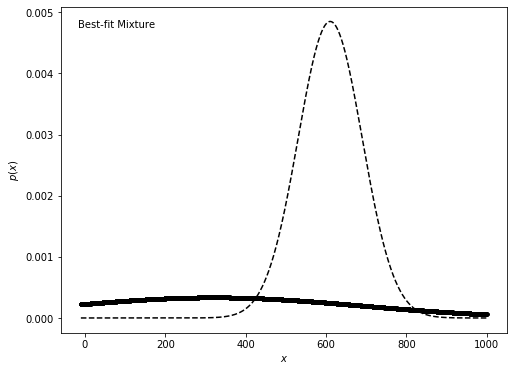

In [188]:
#  
# from https://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html
#   (full example shows how to select the model with lowest AIC)
#
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=False)
x = np.linspace(-10, 1000, 10000)
logprob = BGM.score_samples(x.reshape(-1, 1))
responsibilities = BGM.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
print (pdf_individual)

#ax[0,0] = fig.add_subplot(131)
#ax[0,0].hist(xy1, 50, density=True, histtype='stepfilled', alpha=0.4)
#ax[0,0].plot(x, pdf) #, '-k')
ax[0,0].plot(x, pdf_individual[:,0], '--k')
ax[0,0].plot(x, pdf_individual[:,1]*10, '.k')


ax[0,0].text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax[0,0].transAxes)
ax[0,0].set_xlabel('$x$')
ax[0,0].set_ylabel('$p(x)$')

ValueError: x and y must be the same size

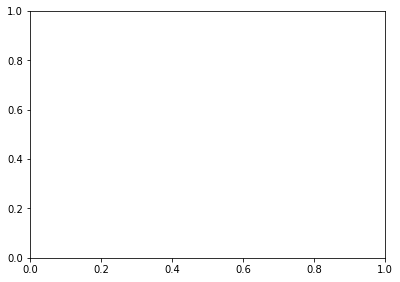

In [140]:
plt.figure(figsize=(14,10))
for i in range(nr_comp):
    plt.subplot(nr_comp,nr_comp,i+1)
    #plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1[idx11])[:,i],cmap='viridis',marker='x')
    plt.scatter(xy1, BGM.predict_proba(xy1)[i],cmap='viridis',marker='x')

In [117]:
import theano.tensor as tt
data = df_input['temp'].values
ndata = data.size

model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=2)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    means = pm.Normal("means", mu=[0, 0], sigma=15, shape=2)
    # break symmetry
    '''
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )
    '''

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data)

In [131]:
map_estimate = pm.find_MAP(model=model) #, method="powell")

In [132]:
map_estimate

{'p_stickbreaking__': array([-105.5628586]),
 'means': array([581.63975217,   0.        ]),
 'sd_interval__': array(219.90625439),
 'category': array([0, 0, 0, ..., 0, 0, 0]),
 'p': array([2.22044605e-16, 1.00000000e+00]),
 'sd': array(20.)}

In [130]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category], proposal = 'uniform')
    tr = pm.sample(10000, step=[step1, step2], tune=2000)

2021-02-07T17:38:47.098 INFO pymc3.sample Multiprocess sampling (4 chains in 4 jobs)
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >>Metropolis: [means]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [sd]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [p]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >CategoricalGibbsMetropolis: [category]


ValueError: Not enough samples to build a trace.

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


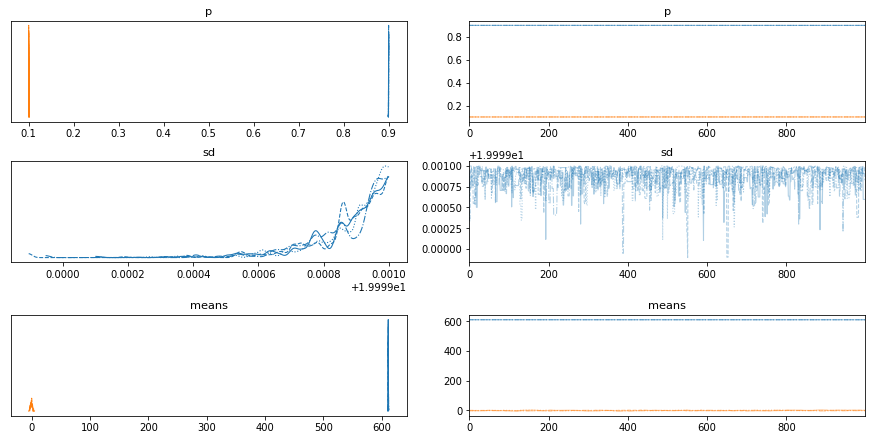

In [121]:
pm.traceplot(tr, var_names=["p", "sd", "means"]);

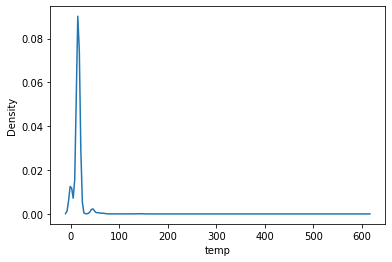

In [104]:
sns.kdeplot(data=df_input2['temp'])

<Figure size 1728x720 with 0 Axes>

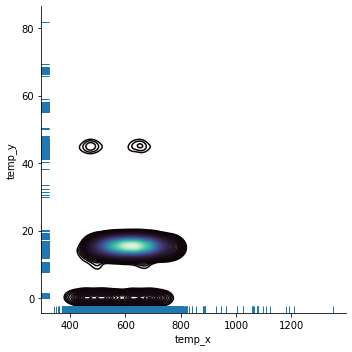

In [89]:
df_merge2 = df_merge.copy()
df_merge2 = df_merge2[df_merge2['temp_y'] < 100]

import seaborn as sns
plt.figure(figsize=(24, 10))
gx = sns.displot(df_merge2[['temp_x','temp_y']], x='temp_x', y='temp_y', 
                 levels=100, kind="kde", cmap="mako", rug=True)
    
#gx.set_titles('KDE for' + df_clean.index.levels[0].values[0])